In [1]:
import pandas as pd
from clickhouse_driver import Client

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import matplotlib

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

In [5]:
import eli5

In [6]:
matplotlib.rcParams["figure.figsize"] = (15, 5)

In [7]:
client = Client('localhost')

# Gas prices

Simple estimator of gas price for transaction between wallets before Constantinople hardfork

Can be pretty useful for Ethereum wallet apps like MetaMask or Multy

### At first we should gather dataset from database

In [8]:
gas_stats = client.execute("""
    SELECT *
    FROM (
        SELECT toInt64(blockNumber / 1000) * 1000 AS block, quantile(0.5)(gasPrice) * 1e9, quantile(0.2)(gasPrice) * 1e9
        FROM eth_internal_transaction
        WHERE 
            (block > 6500000)
        AND
            to NOT IN (SELECT address FROM eth_contract)
        AND
            value > 0
        AND 
            type = 'call'
        AND 
            id LIKE '%.0'
        GROUP BY block
    )
    ANY INNER JOIN (
        SELECT number AS block, timestamp
        FROM eth_block
    )
    USING block
""")

In [9]:
gas_stats_df = pd.DataFrame(gas_stats, columns=["block", "gas", "minGas", "datetime"])

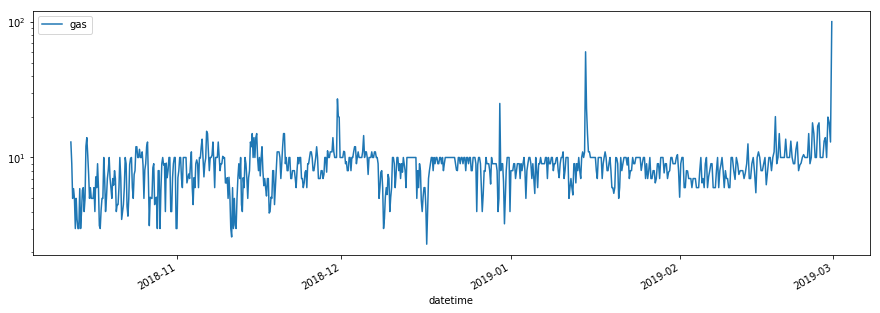

In [30]:
gas_stats_df.sort_values("block").plot(x="datetime", y="gas", logy=True)

### Then we add some periodical features

In [11]:
gas_stats_df["dayofmonth"] = gas_stats_df["datetime"].dt.day
gas_stats_df["dayofweek"] = gas_stats_df["datetime"].dt.dayofweek
gas_stats_df["hour"] = gas_stats_df["datetime"].dt.hour
gas_stats_df["minute"] = gas_stats_df["datetime"].dt.minute

### We are almost there!

Just some preprocessing for train and test dataset...

In [12]:
dataset = gas_stats_df.sort_values("block").set_index("datetime")

columns_for_prediction = ["dayofmonth", "dayofweek", "hour", "minute", "block"]

train_X = dataset[dataset["block"] <= 7000000][columns_for_prediction]
train_y = dataset[dataset["block"] <= 7000000]["gas"]
test_X = dataset[(dataset["block"] > 7000000) & (dataset["block"] < 7200000)][columns_for_prediction]
test_y = dataset[(dataset["block"] > 7000000) & (dataset["block"] < 7200000)]["gas"]

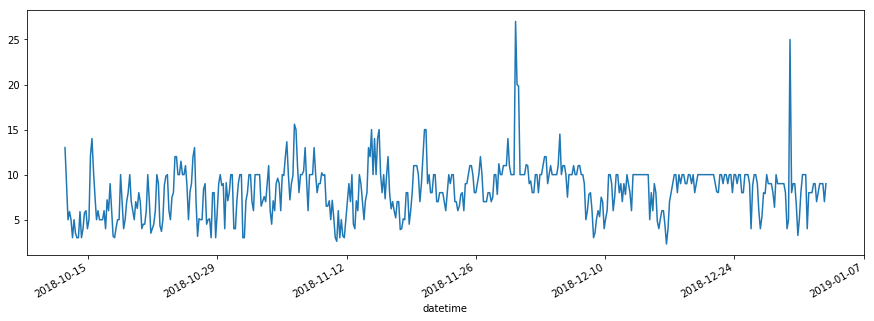

In [34]:
train_y.plot()

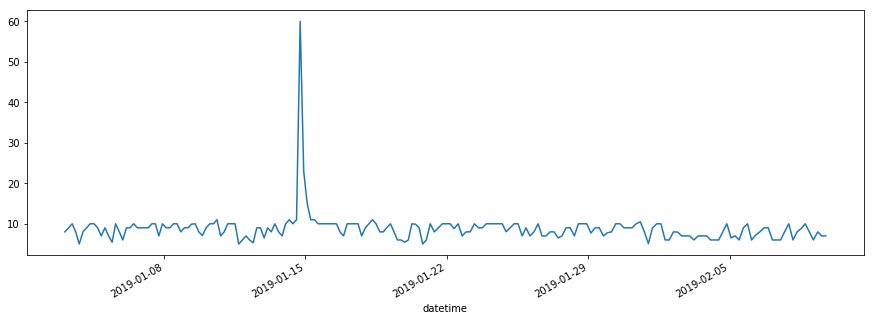

In [35]:
test_y.plot()

### We will choose best model by LMFAO metric

- **Likely Mined** - we want our transactions to be mined after some minutes

- **Fees Are OK** - also we don't want our users to pay impossibly high gas prices

In [15]:
GWEI_THRESHOLD = 5
low_price = gas_stats_df.set_index("block")["minGas"]

In [16]:
def lmfao(estimator, X, y_true):
    y_pred = estimator.predict(X)
    high_fee = ((y_true - y_pred) > GWEI_THRESHOLD)
    will_stuck = (y_pred < low_price.loc[X["block"]].tolist())
    is_proper = ~(high_fee | will_stuck)
    return is_proper.sum() / is_proper.shape[0]

### The Grid Search magic happens here

In [17]:
grid = {
    'n_estimators': np.arange(100, 1000, 100)
}
model = RandomForestRegressor()
split = TimeSeriesSplit(n_splits=10).split(train_X, train_y)
search = GridSearchCV(model, grid, cv=split, scoring=lmfao, verbose=10)

In [18]:
search.fit(train_X, train_y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.9333333333333333, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ...................... n_estimators=100, score=1.0, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ....... n_estimators=100, score=0.9555555555555556, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.9555555555555556, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s


[CV] ....... n_estimators=100, score=0.9555555555555556, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.8888888888888888, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s


[CV] ...................... n_estimators=100, score=1.0, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ...................... n_estimators=100, score=1.0, total=   0.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV] ...................... n_estimators=100, score=1.0, total=   0.1s
[CV] n_estimators=100 ................................................
[CV] ....... n_estimators=100, score=0.9777777777777777, total=   0.1s
[CV] n_estimators=200 ................................................
[CV] ....... n_estimators=200, score=0.9333333333333333, total=   0.2s
[CV] n_estimators=200 ................................................
[CV] ...................... n_estimators=200, score=1.0, total=   0.2s
[CV] n_estimators=200 ................................................
[CV] ....... n_estimators=200, score=0.9777777777777777, total=   0.2s
[CV] n_estimators=200 ................................................
[CV] ....... n_estimators=200, score=0.9333333333333333, total=   0.2s
[CV] n_estimators=200 ................................................
[CV] ....... n_estimators=200, score=0.9777777777777777, total=   0.2s
[CV] n_estimators=200 ................................................
[CV] .

[CV] ...................... n_estimators=700, score=1.0, total=   0.8s
[CV] n_estimators=700 ................................................
[CV] ...................... n_estimators=700, score=1.0, total=   0.8s
[CV] n_estimators=700 ................................................
[CV] ...................... n_estimators=700, score=1.0, total=   0.9s
[CV] n_estimators=700 ................................................
[CV] ....... n_estimators=700, score=0.9777777777777777, total=   1.0s
[CV] n_estimators=800 ................................................
[CV] ....... n_estimators=800, score=0.9555555555555556, total=   0.6s
[CV] n_estimators=800 ................................................
[CV] ...................... n_estimators=800, score=1.0, total=   0.7s
[CV] n_estimators=800 ................................................
[CV] ....... n_estimators=800, score=0.9555555555555556, total=   0.7s
[CV] n_estimators=800 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   51.0s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7ff3a70481a8>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function lmfao at 0x7ff3a7034510>, verbose=10)

### Some explanations - how often does gas price change?

In [19]:
eli5.explain_weights(search.best_estimator_, feature_names=train_X.columns.tolist())

Weight,Feature
0.2978 ± 0.1328,block
0.2517 ± 0.1021,hour
0.1923 ± 0.1189,dayofweek
0.1612 ± 0.0910,dayofmonth
0.0969 ± 0.0716,minute


### Visualization of predictions

In [20]:
predicted_test_y = pd.DataFrame(search.predict(test_X), index=test_y.index)

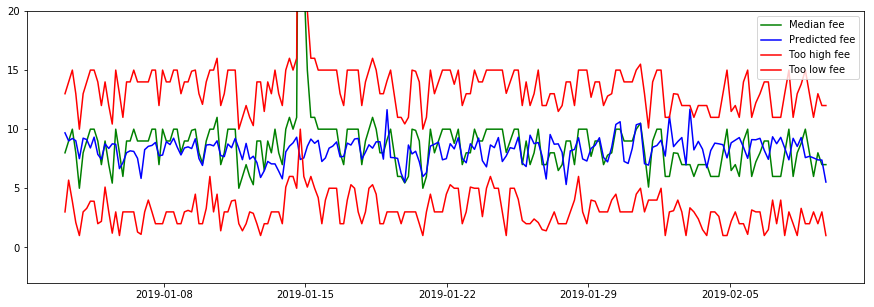

In [27]:
plt.plot(test_y, label="Median fee", color="green")
plt.plot(predicted_test_y, label="Predicted fee", color="blue")
plt.plot(test_y + GWEI_THRESHOLD, label="Too high fee", color="red")
plt.plot(test_y.index, low_price.loc[test_X["block"]].tolist(), label="Too low fee", color="red")
plt.ylim((-3, 20))
plt.legend()

In [28]:
lmfao(search, test_X, test_y)

0.9849246231155779

Seems like this estimator can predict gas price of common ethereum transaction with 98% LMFAO. 

If you want to improve this result, you are welcome ;)